In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *
import shap
import seaborn as sns
from tqdm import tqdm
import pingouin as pg
import pandas as pd
import scipy
import statannot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/home/xiaowei/miniconda3/envs/bci/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
create_folder = lambda folder_name: os.makedirs(folder_name) if not os.path.exists(folder_name) else None
def get_fake_epoch(folder_name,main_path,model_type):
    epoch = loadpkl(main_path + 'preprocessing/' + folder_name + '/final_eye_close_1001_epoch_concat.pkl')
    return epoch
def mappshap(shap_values):
    # input: 4836 as Channel from 0 to 30, after freq from 0 to 155
    # output: (31,156,2)
    shap = np.zeros((31,78,2))
    t = 0
    for s in range(2):
        for i in range(31):
            for j in range(78):
                shap[i,j,s] = shap_values[t]
                t += 1
    return shap

Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


# Feature Importance

Show the difference of subjects

### Define some global paths and parameters

In [3]:
main_path = '/data/xiaowei/social_network/HENU/'
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
model_type = 'XGBRegressor'
method = 'PSD'
seed = 187
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])
file_path = '/data/xiaowei/social_network/HENU/figs_final/feature_importance'

### Plot all in one result

In [15]:
import ast
AIO_metric = 'r2_score'
data = pd.read_csv(main_path + 'AIO_regression/' + folder_name + f'/{model_type}_{AIO_metric}.csv')
data = ast.literal_eval(data['value'][0])[seed]
df = pd.DataFrame(columns=['SHAP/Feature Importance','Term','Eye'])
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        key = f'{term}_{event}'
        df = df.append({'SHAP/Feature Importance': data[key], 'Term': term, 'Eye': event}, ignore_index=True)
print(df)
plt.figure(figsize=(8,6))
sns

   SHAP/Feature Importance     Term        Eye
0                 0.616478    final  eye_close
1                 0.666095    final   eye_open
2                 0.582628  midterm  eye_close
3                 0.594829  midterm   eye_open


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


### Load Data

In [4]:
create_folder(file_path)
Data = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_Dataset.pkl')
model = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_model.pkl')
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
X_test = Data['X_val']
y_test = Data['y_val']
X_key_test = Data['X_key_val']
EEG_featuremap = Data['EEG_featuremap']
shap_values_dict = dict()
shap_scaler_dict = dict()
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        print(f"term: {term}, event: {event}")
        idx = np.isin(X_key_test,f"{term}_{event}_True")+np.isin(X_key_test,f"{term}_{event}_False") != 0
        feature_names_array = np.array(EEG_featuremap[term][event+'_PSD'])[0] # channel+frequency
        feature_names = np.concatenate([np.stack([f"S{subj}_CH{feature_names_array[i][0]:.0f}_F{feature_names_array[i][1]:.2f}" 
                            for i in range(feature_names_array.shape[0])])
                            for subj in ['A','B']])
        psd_idx = np.array(sorted(np.unique(feature_names_array[:,1])))
        explainer = shap.TreeExplainer(model,feature_names=feature_names)
        shap_values = np.abs(explainer.shap_values(X_test[idx]))
        shap_values_organized = np.stack([mappshap(shap_values[i]) for i in range(shap_values.shape[0])]) # (n_sample,31,78,2)
        shap_scaler_dict[f"{term}_{event}"] = {'mean':shap_values_organized.mean(),'std':shap_values_organized.std()}
        for ib,band in enumerate(EEG_bands.keys()):
            idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
            shap_values_dict[f"{term}_{event}_{band}"] = shap_values_organized[:,:,idx,:].mean(2) #(n_sample,31,2)

term: final, event: eye_close


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


term: final, event: eye_open
term: midterm, event: eye_close
term: midterm, event: eye_open


### plot topo map for Subj X Band

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


KeyboardInterrupt: 

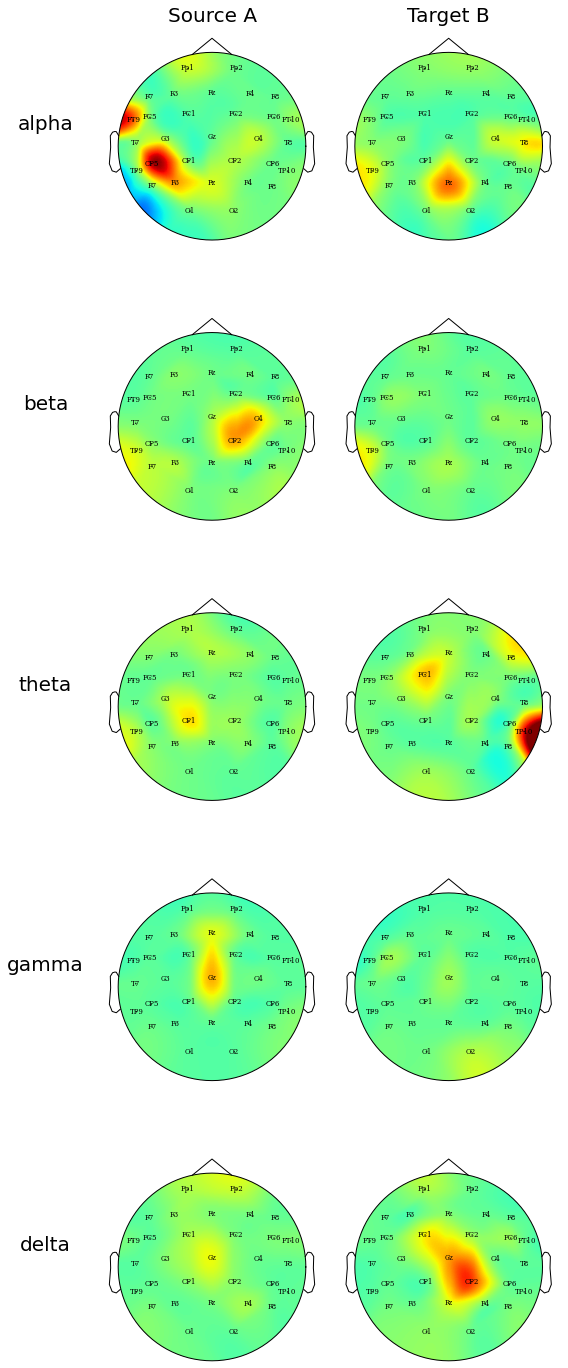

In [5]:

fig = plt.figure(figsize = (8,20))
csfont = {'fontname':'Times New Roman'}
for ib,band in enumerate(EEG_bands.keys()):
    data_band = []
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            data = shap_values_dict[f"{term}_{event}_{band}"]
            data = (data - shap_scaler_dict[f"{term}_{event}"]['mean']) / shap_scaler_dict[f"{term}_{event}"]['std']
            data_band.append(data.mean(0))
    data_band = np.stack(data_band)
    for isubj,subj in enumerate(['Source A','Target B']):
        plt.subplot(5,2,ib*2+isubj+1)
        # plt.title(f'{subj}_{band}')

        mne.viz.plot_topomap(data = data_band[:,:,isubj].mean(0),pos = epoch.info,
                        names = epoch.info['ch_names'],
                        show_names = True,
                        vmin = -1.5,vmax = 1.5,
                        cmap = 'jet',show = False,
                        contours = 0)
        if isubj == 0:
            plt.ylabel(f'{band}',rotation = 0,fontsize = 20,labelpad = 50,**csfont)
        if ib == 0:
            plt.title(f'{subj}',rotation = 0,fontsize = 20,**csfont)
plt.tight_layout()
plt.savefig(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_shap.png',dpi = 1000)

### Plot Bar

Load data

In [116]:
import warnings
warnings.filterwarnings('ignore')
categories = ch_name
# define which channel will be draw in this figure
ch_use = {
    'alpha':['FT9','CP5','Pz','T8'],
    'beta':['CP2','C4'],
    'theta':['CP1','FC1','F8','TP10'],
    'gamma': ['Cz'],
    'delta': ['Cz','CP2']
    }
# generate the datafram
df = pd.DataFrame(columns=['shap','channel','term','event','band','subj'])
for ib,band in tqdm(enumerate(EEG_bands.keys())):
    for event in ['eye_close','eye_open']:
        for term in ['final','midterm']:
            data = shap_values_dict[f"{term}_{event}_{band}"]
            data = (data - shap_scaler_dict[f"{term}_{event}"]['mean']) / shap_scaler_dict[f"{term}_{event}"]['std']
            for isubj,subj in enumerate(['Source A','Target B']):
                for ich,ch in enumerate(ch_name):
                    if ch in ch_use[band]:
                        for isam in range(data.shape[0]):
                            df = df.append({
                                'shap':data[isam,ich,isubj],
                                'channel':ch,
                                'term':term,
                                'event':event,
                                'band':band,
                                'subj':subj,
                                'sample':isam
                                },ignore_index=True)

final_eye_close_alpha: 2it [00:06,  3.23s/it]
midterm_eye_close_alpha: 2it [00:06,  3.42s/it]
final_eye_open_alpha: 2it [00:07,  3.62s/it]
midterm_eye_open_alpha: 2it [00:07,  3.84s/it]
final_eye_close_beta: 2it [00:04,  2.01s/it]
midterm_eye_close_beta: 2it [00:04,  2.04s/it]
final_eye_open_beta: 2it [00:04,  2.12s/it]
midterm_eye_open_beta: 2it [00:04,  2.17s/it]
final_eye_close_theta: 2it [00:08,  4.49s/it]
midterm_eye_close_theta: 2it [00:09,  4.68s/it]
final_eye_open_theta: 2it [00:09,  4.92s/it]
midterm_eye_open_theta: 2it [00:10,  5.14s/it]
final_eye_close_gamma: 2it [00:02,  1.33s/it]
midterm_eye_close_gamma: 2it [00:02,  1.34s/it]
final_eye_open_gamma: 2it [00:02,  1.35s/it]
midterm_eye_open_gamma: 2it [00:02,  1.37s/it]
final_eye_close_delta: 2it [00:05,  2.74s/it]
midterm_eye_close_delta: 2it [00:05,  2.81s/it]
final_eye_open_delta: 2it [00:05,  2.87s/it]
midterm_eye_open_delta: 2it [00:05,  2.91s/it]


['Source A-final' 'Source A-midterm' 'Target B-final' 'Target B-midterm']


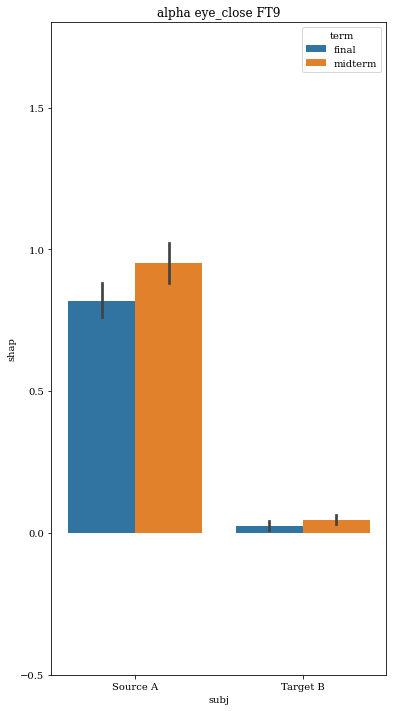

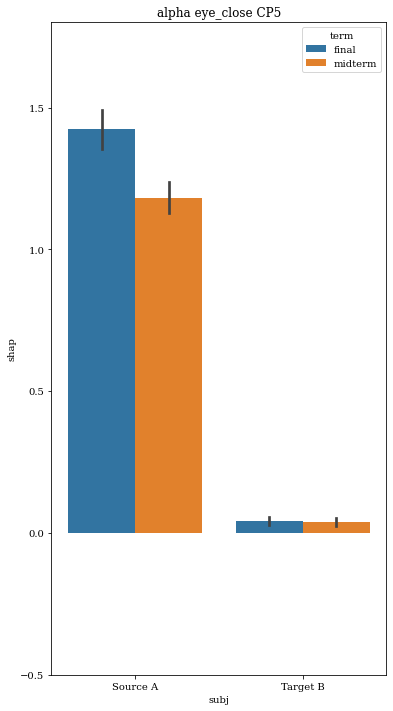

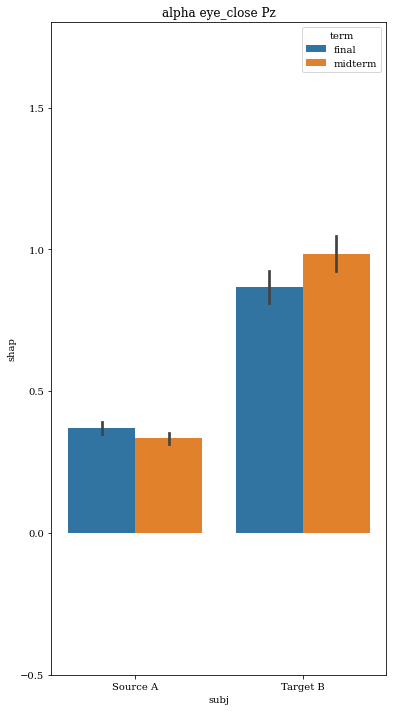

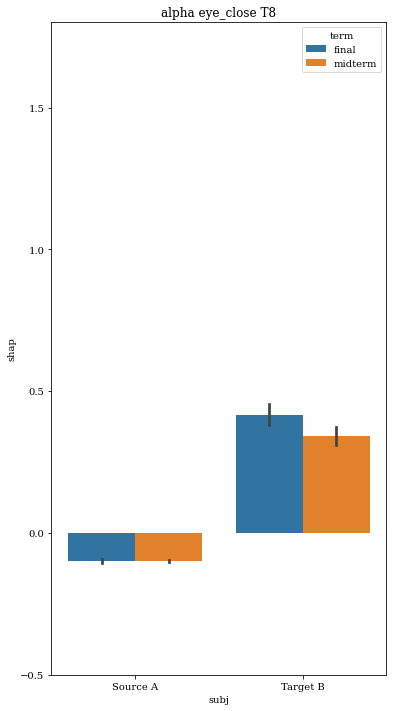

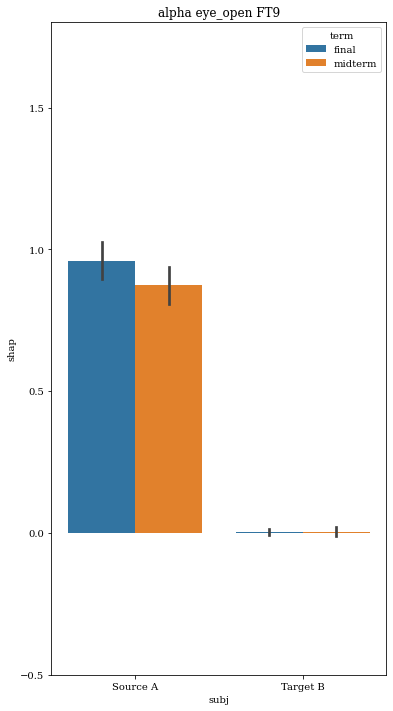

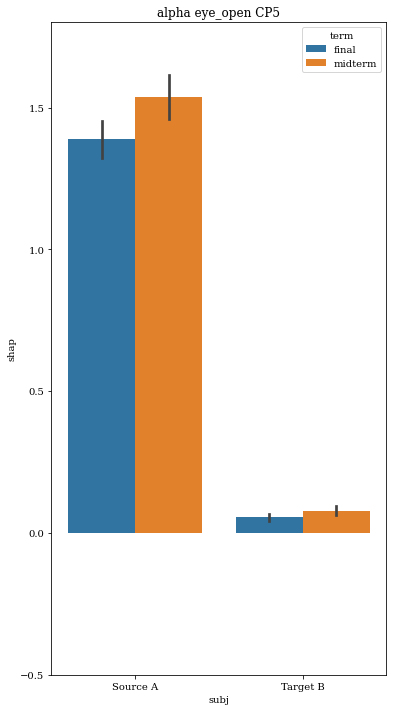

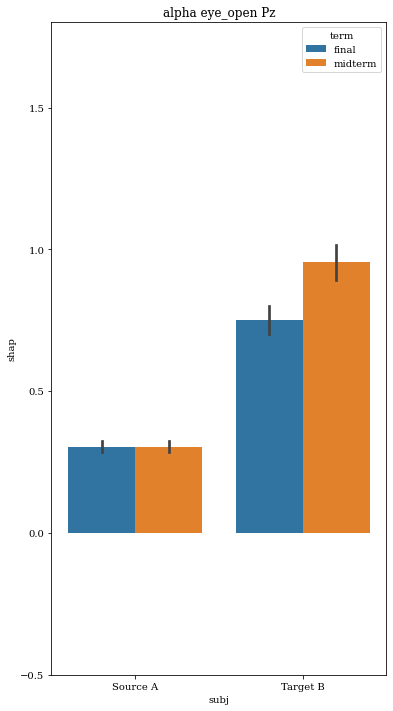

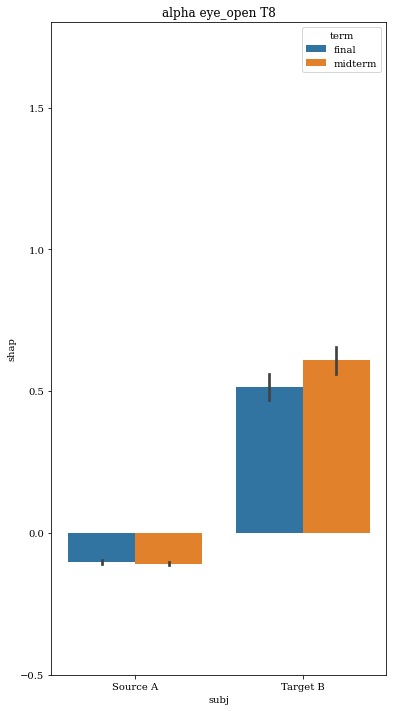

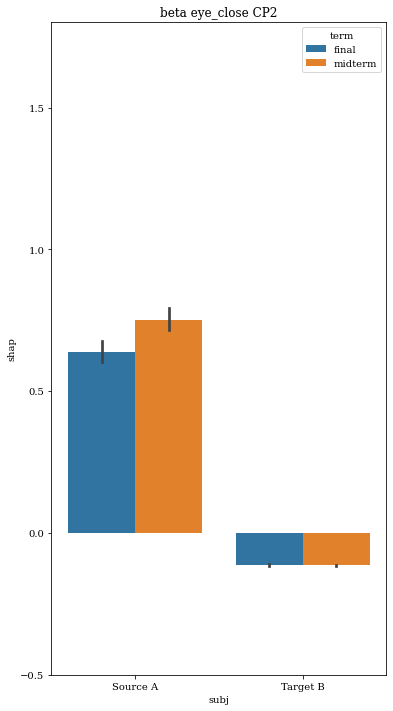

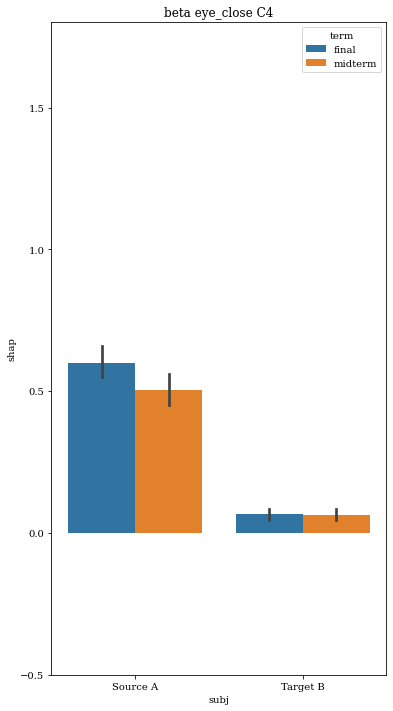

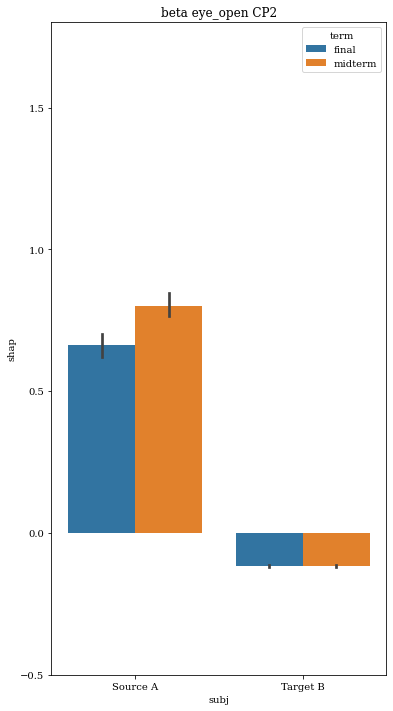

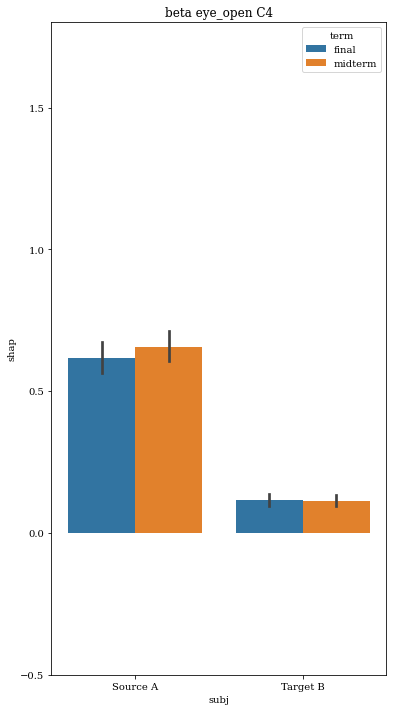

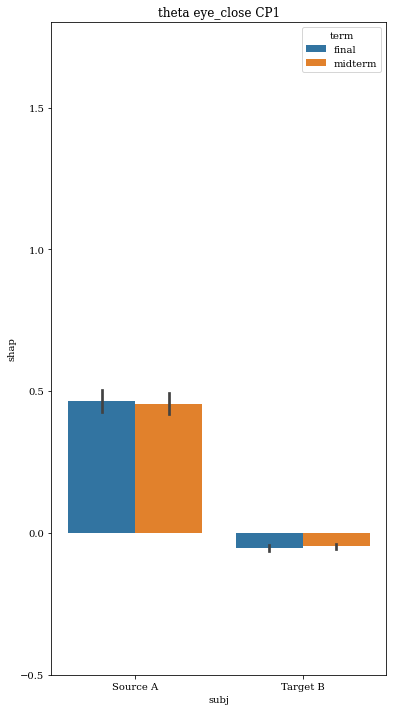

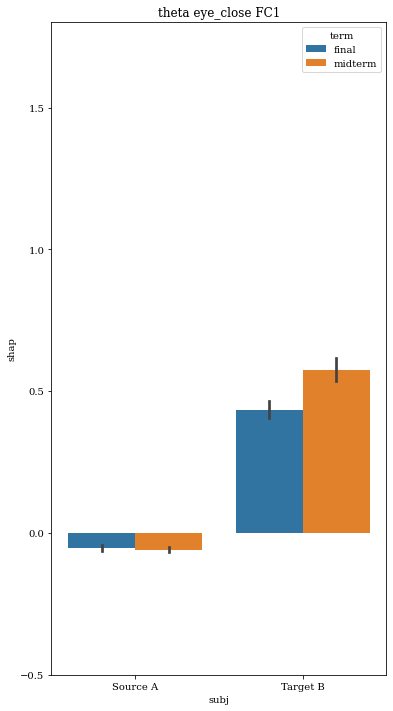

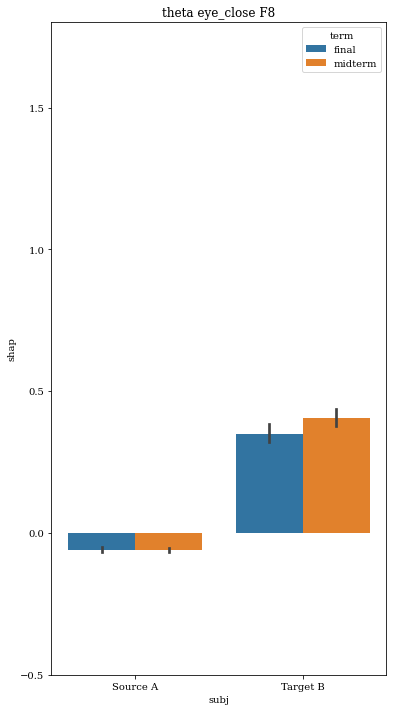

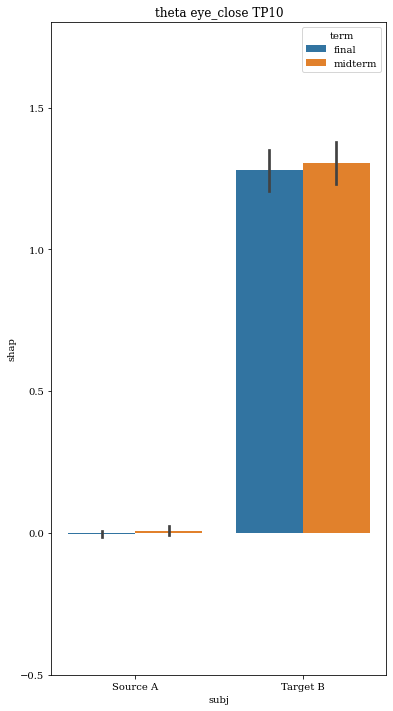

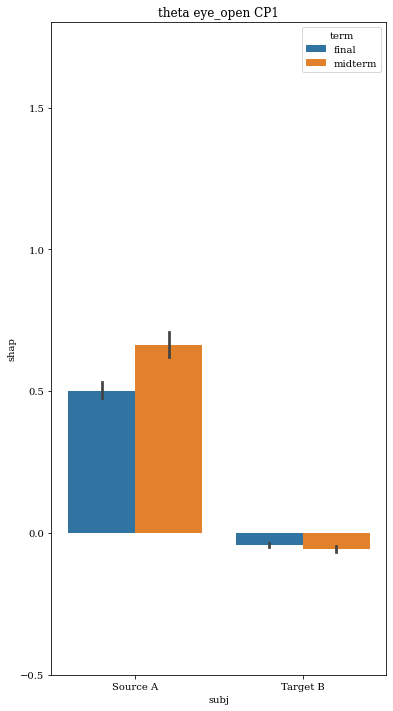

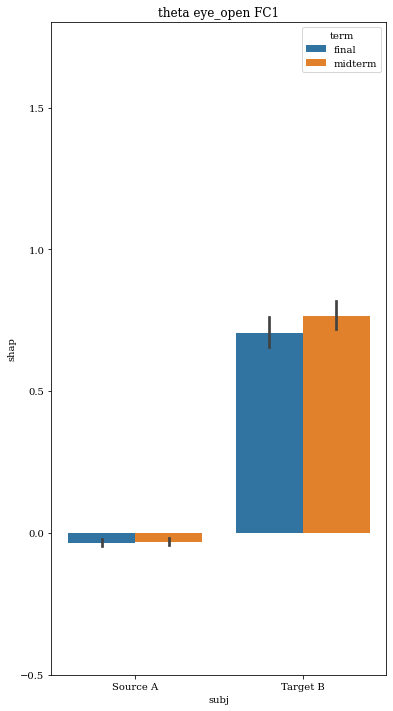

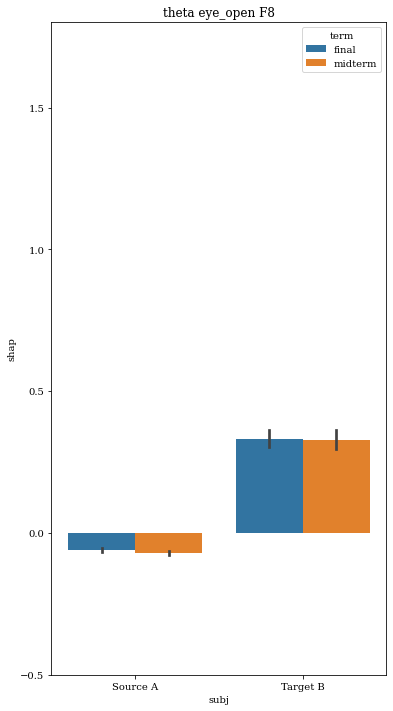

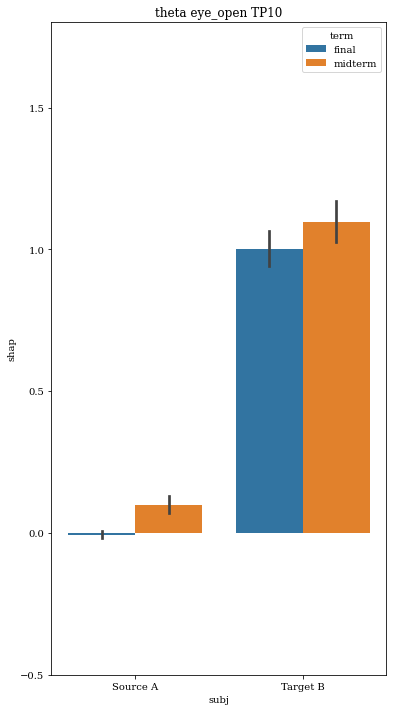

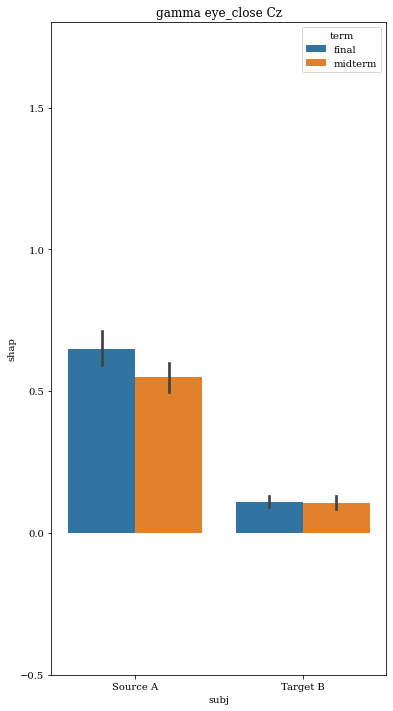

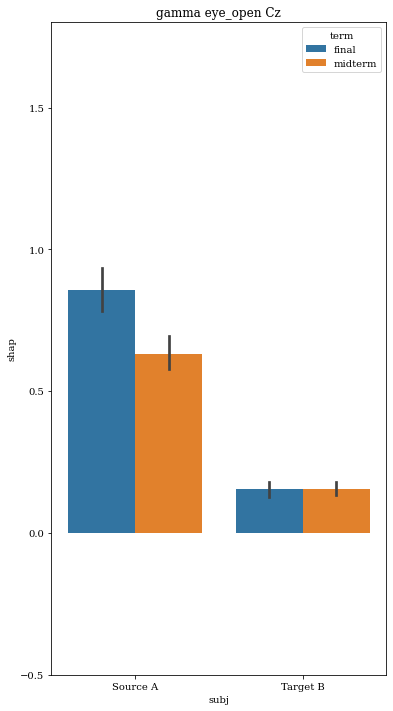

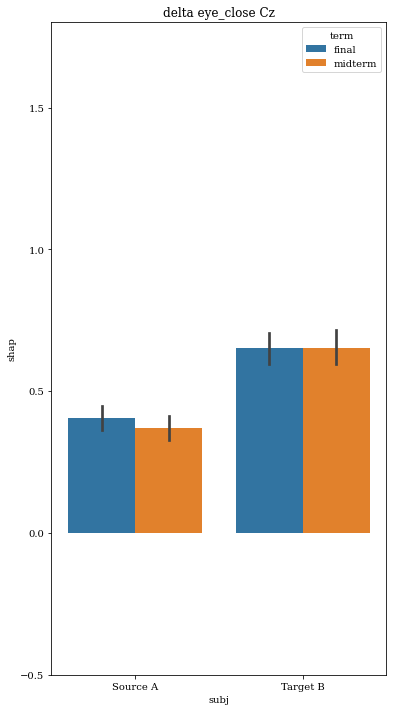

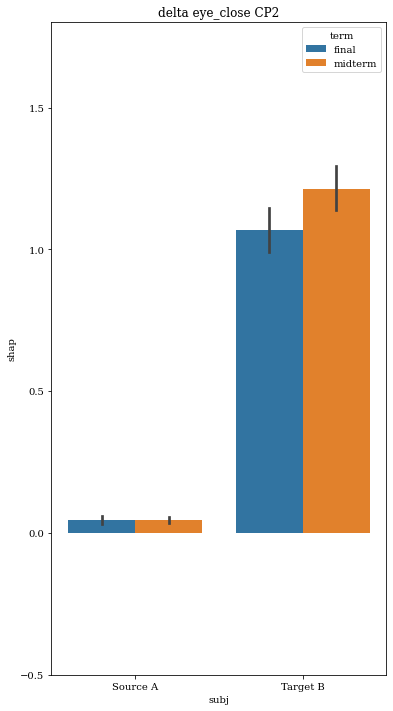

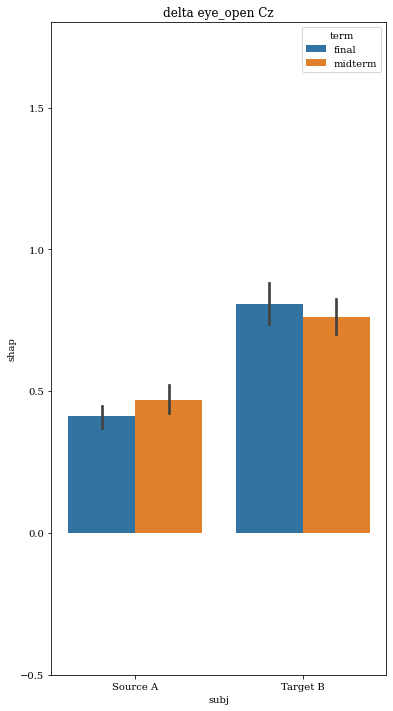

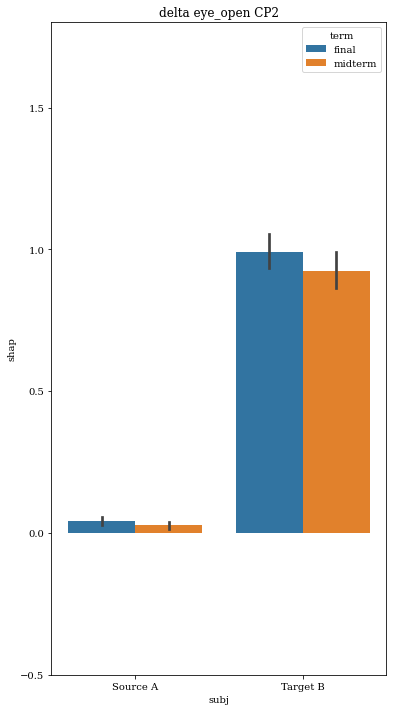

In [149]:

df["subj-term"] = df["subj"].map(str) + "-" + df["term"].map(str)
print(np.unique(df["subj-term"]))
for ib,band in enumerate(EEG_bands.keys()):
    
    box_pairs=  [((ch,'Source A-final'),(ch,'Source A-midterm')) for ch in ch_use[band]]+\
                [((ch,'Target B-final'),(ch,'Target B-midterm')) for ch in ch_use[band]]+\
                [((ch,'Source A-final'),(ch,'Target B-final')) for ch in ch_use[band]]+\
                [((ch,'Source A-midterm'),(ch,'Target B-midterm')) for ch in ch_use[band]]
    for event in ['eye_close','eye_open']:
        
        data = df[df['band']==band][df['event']==event]
        for ch in ch_use[band]:
            fig,ax = plt.subplots(figsize=(6,12))
            sns.barplot(x='subj',y='shap',hue='term',data=data[data['channel']==ch],ax=ax)
            # ax.get_legend().remove()
            plt.title(f'{band} {event} {ch}')
            plt.ylim(-0.5,1.8)
            # statannot.add_stat_annotation(ax, data=data, x='channel', y='shap', hue="subj-term",order=ch_use[band],
            #                                 comparisons_correction='bonferroni', test='Mann-Whitney',
            #                                 box_pairs=box_pairs,verbose=2)
            plt.show()








